In [1]:
import MySQLdb
import datetime
import pandas as pd
import numpy as np
import collections

In [695]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_context('poster')
sns.set_style('darkgrid')
%matplotlib inline

import matplotlib
zhfont = matplotlib.font_manager.FontProperties(fname='/home/********/wqy-microhei.ttc', size=22)

In [693]:
sql_params = {'host': "********",
              'db' : "********",
              'user': "********",
              'passwd': "********",
              'charset': 'utf8'}

In [4]:
# Open database connection
connection = MySQLdb.connect (**sql_params)

# Primary Stats Rates.R

In [113]:
td_str = '20170808'
td = datetime.datetime.strptime(td_str, '%Y%m%d')
print td
sql_query = "".join(["SELECT   c.*, d.S_INFO_WINDCODE, d.TRADE_DT, d.B_ANAL_YIELD_CNBD FROM( ",
               "SELECT ifnull(a.S_INFO_FORMERWINDCODE, a.S_INFO_WINDCODE) AS ticker, a.S_INFO_WINDCODE, a.S_INFO_NAME, ",
               "a.B_INFO_TERM_YEAR_, a.B_INFO_ISSUERCODE, a.B_INFO_CARRYDATE, a.B_ISSUE_FIRSTISSUE, ",
               "a.B_ISSUE_AMOUNTPLAN, a.IS_FAILURE, a.B_INFO_LISTDATE, ",
               "a.B_INFO_MATURITYDATE, a.B_INFO_COUPONRATE, b.S_IPO_OVRSUBRATIO, ",
               "b.B_TENDER_OBJECT, b.B_TENDRST_HIGHTEST, b.B_TENDRST_LOWEST, ",
               "b.B_TENDRST_FINALPRICE, ifnull(b.B_TENDRST_REFERYIELD, b.B_TENDRST_BIDRATE) AS yield, ",
               "b.B_TENDRST_OUGHTTENDER, b.B_TENDRST_INVESTORTENDERED, b.B_TENDRST_WINNERBIDDER, ",
               "b.B_TENDRST_EFFECTTENDER, b.B_TENDRST_WINNINGBIDDER ",
               "FROM CBONDDESCRIPTION a LEFT JOIN CBONDTENDERRESULT b ON a.S_INFO_WINDCODE = b.S_INFO_WINDCODE ",
               "WHERE a.B_INFO_ISSUERTYPE IN ('财政部', '政策性银行') ",
               "AND a.B_INFO_COUPON <> '505003000' ",
               "AND a.B_INFO_INTERESTTYPE = '501002000'",
               "AND a.B_INFO_SPECIALBONDTYPE IS NULL ",
               "AND a.B_INFO_LISTDATE IS NOT NULL ",
               "AND a.B_ISSUE_FIRSTISSUE > '20130101' ",
               "AND a.S_INFO_EXCHMARKET = 'NIB' ",
               # "AND a.S_INFO_WINDCODE LIKE '140016%' ",
               ") c LEFT JOIN CBONDANALYSISCNBD d ",
               "ON c.ticker = d.S_INFO_WINDCODE ",
               "AND date_add(str_to_date(c.B_ISSUE_FIRSTISSUE, '%Y%m%d'), INTERVAL 3 MONTH) > str_to_date(d.TRADE_DT, '%Y%m%d') ",
               "AND date_sub(str_to_date(c.B_ISSUE_FIRSTISSUE, '%Y%m%d'), INTERVAL 1 MONTH) <= str_to_date(d.TRADE_DT, '%Y%m%d') ",
               "AND d.B_ANAL_CREDIBILITY = '推荐' "])

data = pd.read_sql(sql_query, connection)

2017-08-08 00:00:00


In [114]:
my_columns = ["px.ticker","id.ticker","name","term","issuer","dt.carry", "dt.issue","amt.issue","failure","dt.list","dt.mature",
                   "cpn","over.sub.ratio","td.type","td.high","td.low","td.px","td.yld","bidder.max","bidder.in","bidder.won",
                   "bids.effect","bids.win","ref.ticker","ref.dt","ref.yld"]
data.columns = my_columns
print data.shape
print data.dtypes
data.head()

(173161, 26)
px.ticker          object
id.ticker          object
name               object
term              float64
issuer             object
dt.carry           object
dt.issue           object
amt.issue         float64
failure           float64
dt.list            object
dt.mature          object
cpn               float64
over.sub.ratio    float64
td.type           float64
td.high           float64
td.low            float64
td.px             float64
td.yld            float64
bidder.max        float64
bidder.in         float64
bidder.won        float64
bids.effect       float64
bids.win          float64
ref.ticker         object
ref.dt             object
ref.yld           float64
dtype: object


,px.ticker,id.ticker,name,term,issuer,dt.carry,dt.issue,amt.issue,failure,dt.list,dt.mature,cpn,over.sub.ratio,td.type,td.high,td.low,td.px,td.yld,bidder.max,bidder.in,
0,150220.IB,150220Z6.IB,15国开20(增6),5,2002700,20150924,20151117,40,0,20151123,20200924,3.46,5,530003000,103.48,99.04,101.16,3.3154,76,38,...
1,150220.IB,150220Z6.IB,15国开20(增6),5,2002700,20150924,20151117,40,0,20151123,20200924,3.46,5,530003000,103.48,99.04,101.16,3.3154,76,38,...
2,150220.IB,150220Z6.IB,15国开20(增6),5,2002700,20150924,20151117,40,0,20151123,20200924,3.46,5,530003000,103.48,99.04,101.16,3.3154,76,38,...
3,150220.IB,150220Z6.IB,15国开20(增6),5,2002700,20150924,20151117,40,0,20151123,20200924,3.46,5,530003000,103.48,99.04,101.16,3.3154,76,38,...
4,150220.IB,150220Z6.IB,15国开20(增6),5,2002700,20150924,20151117,40,0,20151123,20200924,3.46,5,530003000,103.48,99.04,101.16,3.3154,76,38,...


In [115]:
def cleanRatesData(df):
    df.loc[:, 'reopen'] = (df.loc[:, 'px.ticker'] == df.loc[:, 'id.ticker']).astype(int)
    for col in ['dt.issue', 'dt.list', 'dt.mature', 'ref.dt']:
        df.loc[:, col] = pd.to_datetime(df.loc[:, col], format="%Y%m%d")
    
    # seperate bond info and bond price  
    bond_info_columns = [col for col in list(df.columns) if col not in ['ref.ticker', 'ref.dt', 'ref.yld'] ]
    bond_info = df.loc[:, bond_info_columns].copy()
    bond_info = bond_info.drop_duplicates()
    
    # regroup bond price by term and issuer, rather than by ticker
    bond_px_columns = ['issuer', 'term', 'px.ticker', 'ref.dt', 'ref.yld']
    bond_px = df.loc[:, bond_px_columns].copy()
    bond_px.columns = ['issuer', 'term', 'ref.ticker', 'ref.dt', 'ref.yld']
    
    mask_null = np.logical_or(df.loc[:, 'ref.dt'].isnull(), df.loc[:, 'ref.yld'].isnull())
    mask_null = np.logical_not(mask_null)
    bond_px = bond_px.loc[mask_null, :] # get the price history
    bond_px = bond_px.drop_duplicates() 
    #bond_px = bond_px.sort_index(axis=0, by='ref.ticker')
    grouped = bond_px.groupby(by=['issuer', 'term', 'ref.dt'], as_index=False) # select only the most recent issue for each issuer / term / date
    bond_px = grouped.head(n=1) #TODO
    print "Sort top n by ref.ticker???"
    return df, bond_info, bond_px

data_x, bond_info, bond_px = cleanRatesData(data)

Sort top n by ref.ticker???


In [146]:
# rejoin bond info with bond price, by term and issuer
data_join = pd.merge(bond_info, bond_px, how='outer', left_on=['issuer', 'term'], right_on=['issuer', 'term'])# join yld history by issuer and term
data_join = data_join.loc[data_join.loc[:, 'dt.issue'] > data_join.loc[:, 'ref.dt'], :] # limit range to 30 days before issue

In [148]:
grouped = data_join.groupby(by='id.ticker', as_index=False)
data_join = grouped.head(1)

In [149]:
data_join.loc[:, 'dt.diff'] = data_join.loc[:, 'dt.issue'] - data_join.loc[:, 'ref.dt']
data_join = data_join.sort_index(axis=0, by='id.ticker')
print data_join.shape
data_join.head()

(2316, 28)


,px.ticker,id.ticker,name,term,issuer,dt.carry,dt.issue,amt.issue,failure,dt.list,dt.mature,cpn,over.sub.ratio,td.type,td.high,td.low,td.px,td.yld,bidder.max,bidder.in,
1224680,070205.IB,070205Z.IB,07国开05(增发),7,2002700,20070424,2014-01-17,50,0,2014-01-28,2014-04-24,3.82,2.76,530003000,102.67,102.52,102.552,4.9594,72,17,...
1158328,070205.IB,070205Z2.IB,07国开05(增2),7,2002700,20070424,2014-01-21,40,0,2014-02-08,2014-04-24,3.82,1.52,530003000,102.83,102.56,102.634,4.9044,72,15,...
986764,110215.IB,110215Z.IB,11国开15(增发),3,2002700,20110322,2013-12-19,50,0,2013-12-30,2014-03-22,3.83,1.11,530003000,102.53,102.50,102.508,5.3491,72,11,...
928420,110234.IB,110234Z.IB,11国开34(增发),3,2002700,20110602,2014-02-20,50,0,2014-02-28,2014-06-02,4.00,7.95,530003000,102.85,102.73,102.850,1.9917,72,30,...
470533,110413.IB,110413Z.IB,11农发13(增发),3,04M5F620A3,20110729,2014-04-09,100,0,2014-04-17,2014-07-29,4.50,2.91,530003000,103.38,103.14,103.296,3.9031,77,36,...


In [150]:
def get_bond_upcoming(larger, smaller):
    s1 = set(larger.loc[:, 'id.ticker'].drop_duplicates())
    s2 = set(smaller.loc[:, 'id.ticker'].drop_duplicates())
    return list(s1.difference(s2))
bond_upcoming = get_bond_upcoming(data_x, data_join)

In [380]:
mask = bond_info.loc[:, 'id.ticker'].apply(lambda x: x in bond_upcoming)
data_x = pd.concat([bond_info.loc[mask, :], data_join], axis=0)
print data_x.shape

(2350, 28)


In [381]:
def firstDayOfWeek(dt):
    t = dt - datetime.timedelta(dt.weekday())
    return datetime.date(t.year, t.month, t.day)
    
def firstDayOfMonth(dt):
    t = dt.replace(day=1)
    return datetime.date(t.year, t.month, t.day)
def map_term_to_sector(t):
    if t <= 3:
        res = "Short"
    else:
        if t <= 7:
            res = "Mid"
        elif t == 10:
            res = "Ten"
        else:
            res = "Long"
    return res

RATES_ISSUER_DICT = {"2000850": u"国债", "2002700": u"国开", "0MT64BBFB6": u"口行", "04M5F620A3": u"农发"}

def process_data_x(df):
    df = df.copy()
    df.loc[:, 'dur.impact'] = df.loc[:, 'amt.issue'] * df.loc[:, 'term'] / 10.
    df.loc[:, 'term.remain'] = (df.loc[:, 'dt.mature'] - df.loc[:, 'dt.list']) / np.timedelta64(1,'D') /365.25 # remaining term in years
    df.loc[:, 'through'] = (df.loc[:, 'ref.yld'] - df.loc[:, 'td.yld']) * 100.
    df.loc[:, 'dt.month'] = df.loc[:, 'dt.issue'].apply(firstDayOfMonth)
    df.loc[:, 'dt.week'] = df.loc[:, 'dt.issue'].apply(firstDayOfWeek)
    df.loc[:, 'sector'] = df.loc[:, 'term'].apply(map_term_to_sector)
    df.loc[:, 'issuer.name'] = df.loc[:, 'issuer'].apply(lambda key: RATES_ISSUER_DICT[key])
    
    return df

data_x = process_data_x(data_x)
print data_x.shape
data_x.head()

(2350, 35)


,amt.issue,bidder.in,bidder.max,bidder.won,bids.effect,bids.win,cpn,dt.carry,dt.diff,dt.issue,dt.list,dt.mature,failure,id.ticker,issuer,name,over.sub.ratio,px.ticker,ref.dt,ref.ticker,
7859,260,53,54,52,286,159,3.1500,20130110,NaT,2013-01-09,2013-01-16,2018-01-10,0,130001.IB,2000850,13附息国债01,1.92,130001.IB,NaT,NaN,...
13946,30,38,82,14,98,24,3.9500,20160226,NaT,2016-02-24,2016-03-01,2036-02-26,0,160410.IB,04M5F620A3,16农发10,4.61,160410.IB,NaT,NaN,...
20597,60,32,74,17,88,32,4.3251,20130110,NaT,2013-01-08,2013-01-16,2020-01-10,0,130204.IB,2002700,13国开04,2.12,130204.IB,NaT,NaN,...
21468,260,50,50,49,192,181,4.7600,20130916,NaT,2013-09-13,2013-09-23,2043-09-16,0,130019.IB,2000850,13附息国债19,1.13,130019.IB,NaT,NaN,...
23327,150,59,74,42,175,91,4.2400,20130322,NaT,2013-03-15,2013-03-28,2023-03-22,0,130403.IB,04M5F620A3,13农发03,1.43,130403.IB,NaT,NaN,...


In [382]:
data_plot_columns = ["dt.issue", "dt.week", "dt.month", "term", "sector", "issuer.name", "amt.issue", "dur.impact"]
data_plot = data_x.loc[:, data_plot_columns].copy()
print data_plot.shape
data_plot.head()

(2350, 8)


,dt.issue,dt.week,dt.month,term,sector,issuer.name,amt.issue,dur.impact
7859,2013-01-09,2013-01-07,2013-01-01,5,Mid,国债,260,130
13946,2016-02-24,2016-02-22,2016-02-01,20,Long,农发,30,60
20597,2013-01-08,2013-01-07,2013-01-01,7,Mid,国开,60,42
21468,2013-09-13,2013-09-09,2013-09-01,30,Long,国债,260,780
23327,2013-03-15,2013-03-11,2013-03-01,10,Ten,农发,150,150


In [383]:
data_plot_melt = pd.melt(data_plot, id_vars=["dt.issue", "dt.week", "dt.month", "term", "sector", "issuer.name"],)
print data_plot_melt.shape
data_plot_melt.head()

(4700, 8)


,dt.issue,dt.week,dt.month,term,sector,issuer.name,variable,value
0,2013-01-09,2013-01-07,2013-01-01,5,Mid,国债,amt.issue,260
1,2016-02-24,2016-02-22,2016-02-01,20,Long,农发,amt.issue,30
2,2013-01-08,2013-01-07,2013-01-01,7,Mid,国开,amt.issue,60
3,2013-09-13,2013-09-09,2013-09-01,30,Long,国债,amt.issue,260
4,2013-03-15,2013-03-11,2013-03-01,10,Ten,农发,amt.issue,150


In [384]:
#ISSUER_RANK = [u"国债", u"国开", u"口行", u"农发"]
ISSUER_RANK = collections.OrderedDict([(u"国债", 1), (u"国开", 2), (u"口行", 3), (u"农发", 4)])

def get_data_new(df):
    df = df.copy()
    
    mask = df.loc[:, 'dt.issue'] >= td
    cols = ["dt.issue", "issuer.name", "term", "amt.issue", "id.ticker"]
    df = df.loc[mask, cols]
    
    df.loc[:, 'weekday'] = df.loc[:, 'dt.issue'].apply(lambda dt: dt.weekday() + 1)
    
    #df.loc[:, 'issuer.name'] = pd.Categorical(df.loc[:, 'issuer.name'], ISSUER_RANK)
    df.loc[:, 'rank'] = df.loc[:, 'issuer.name'].apply(lambda key: ISSUER_RANK.get(key))
    df = df.sort(columns=['dt.issue', 'rank', 'term'])
    df = df.drop('rank', axis=1)
    return df

data_new = get_data_new(data_x)
print data_new.shape
data_new.head()

(12, 6)


,dt.issue,issuer.name,term,amt.issue,id.ticker,weekday
979733,2017-08-08,国开,3,50,170205Z17.IB,2
140712,2017-08-08,国开,5,70,170206Z15.IB,2
1143325,2017-08-08,国开,7,40,170201Z18.IB,2
681149,2017-08-08,国开,10,140,170210Z18.IB,2
1959260,2017-08-09,国债,2,280,170012X2.IB,3


In [385]:
RATES_RECENT_DAYS_RANGE = 7
def get_data_recent(df):
    df = df.copy()
    
    mask = np.logical_and(df.loc[:, 'dt.issue'] < td, 
                          df.loc[:, 'dt.issue'] >= td-datetime.timedelta(RATES_RECENT_DAYS_RANGE))
    cols = ["dt.issue", "issuer.name", "term", "amt.issue", "id.ticker"]
    df = df.loc[mask, cols]
    
    df.loc[:, 'weekday'] = df.loc[:, 'dt.issue'].apply(lambda dt: dt.weekday() + 1)
    
    #df.loc[:, 'issuer.name'] = pd.Categorical(df.loc[:, 'issuer.name'], ISSUER_RANK)
    df.loc[:, 'rank'] = df.loc[:, 'issuer.name'].apply(lambda key: ISSUER_RANK.get(key))
    df = df.sort(columns=['dt.issue', 'rank', 'term'])
    df = df.drop('rank', axis=1)
    return df

data_recent = get_data_recent(data_x)
print data_recent.shape
data_recent.head()

(15, 6)


,dt.issue,issuer.name,term,amt.issue,id.ticker,weekday
2048128,2017-08-01,国开,1,50,170207Z4.IB,2
117832,2017-08-01,国开,5,70,170206Z14.IB,2
670853,2017-08-01,国开,10,150,170210Z17.IB,2
2389947,2017-08-02,国债,1,360,170017.IB,3
654071,2017-08-02,国债,10,360,170018.IB,3


In [197]:
TERM_RANK = ["Short", "Mid", "Ten", "Long"]

### Total Issuance-  monthly

In [394]:
grouped = data_plot.groupby(by=['dt.month', 'sector'], as_index=False)
grouped.agg({'amt.issue': np.sum, 'dur.impact': np.sum})

,dt.month,sector,amt.issue,dur.impact
0,2013-01-01,Mid,950.0,559.0000
1,2013-01-01,Short,820.0,162.0000
2,2013-01-01,Ten,110.0,110.0000
3,2013-02-01,Mid,1110.0,713.0000
4,2013-02-01,Short,440.0,108.0000
5,2013-02-01,Ten,380.0,380.0000
6,2013-03-01,Mid,1070.0,619.0000
7,2013-03-01,Short,390.0,78.0000
8,2013-03-01,Ten,490.0,490.0000
9,2013-04-01,Long,260.0,520.0000


In [396]:
SECTOR_COLOR_MAP.keys()

['Short', 'Mid', 'Ten', 'Long']

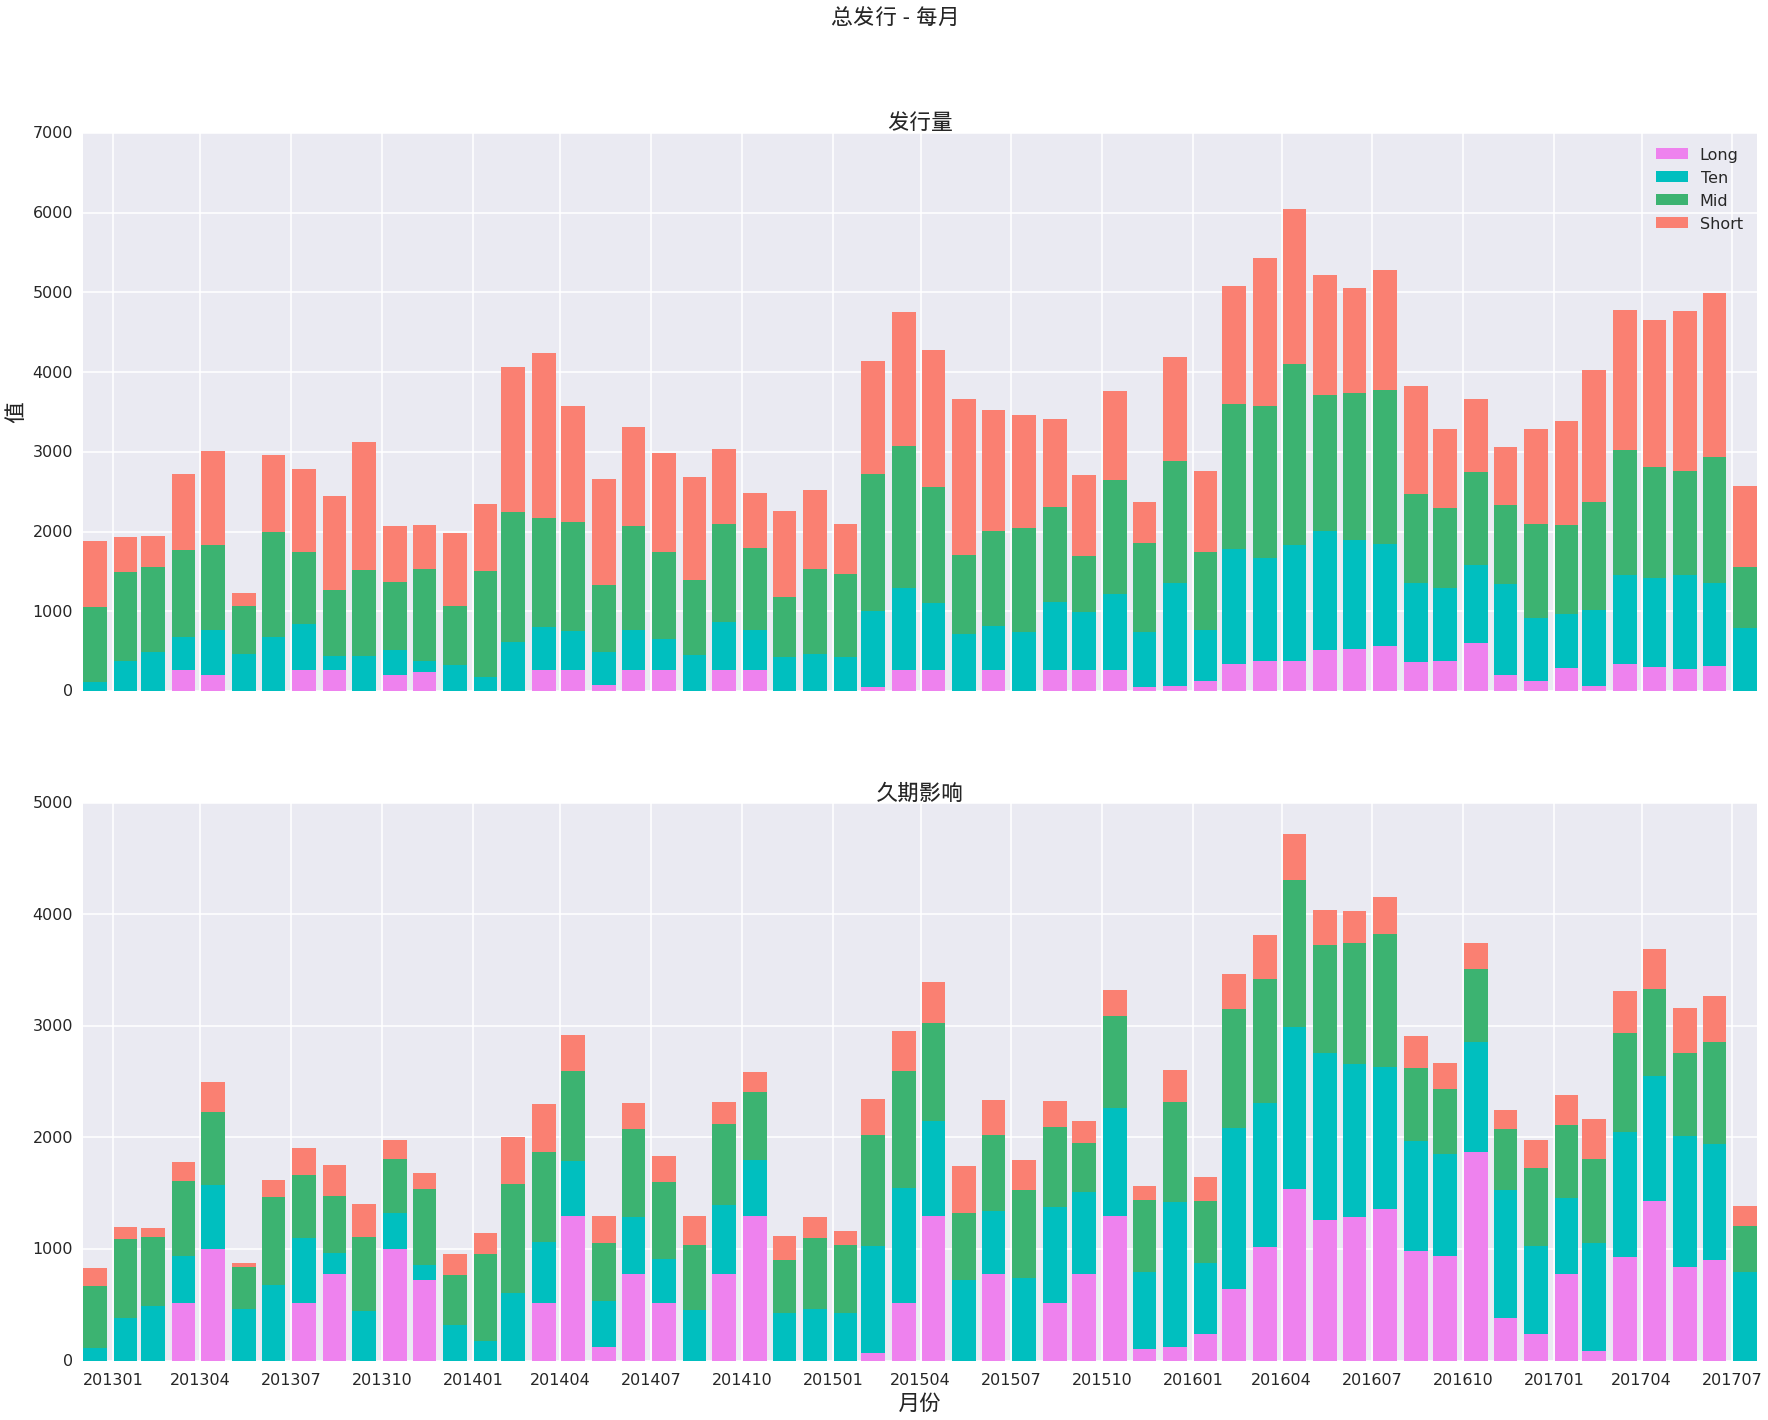

In [705]:
SECTOR_COLOR_MAP = collections.OrderedDict([('Long', 'violet'), ('Ten', 'c'),
                                            ('Mid', 'mediumseagreen'), ('Short', 'salmon')])

def get_factors(df, yname, idxname, factorname):
    idx = np.sort(df.loc[:, idxname].drop_duplicates())
    df.index = pd.DatetimeIndex(df.loc[:, idxname])
    res_df = pd.DataFrame(index=idx, columns=SECTOR_COLOR_MAP.keys())
    
    for factor in SECTOR_COLOR_MAP.keys():
        mask = df.loc[:, factorname] == factor
        source = df.loc[mask, :]
        res_df.loc[source.index, factor] = source.loc[:, yname].values
    res_df = res_df.fillna(0)
    return res_df

def plot_total_issuance(df):
    df = df.copy()
    df.index = df.loc[:, 'dt.month']
    
    grouped = df.groupby(by=['dt.month', 'sector'], as_index=False)
    monthly_sum = grouped.agg({'amt.issue': np.sum, 'dur.impact': np.sum})
    
    mask = np.logical_and(monthly_sum.loc[:, 'dt.month'] >= datetime.date(2013, 1, 1), 
                          monthly_sum.loc[:, 'dt.month'] < datetime.date(td.year, td.month, td.day) + datetime.timedelta(14))
    monthly_sum = monthly_sum.loc[mask, :]
    
    df_issue_plot = get_factors(monthly_sum, 'amt.issue', 'dt.month', 'sector')
    df_impact_plot = get_factors(monthly_sum, 'dur.impact', 'dt.month', 'sector')
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(30, 22), dpi=300)
    common_styles = {'edgecolor': '', 'width': 24.0}
    
    last_values = np.zeros(df_issue_plot.shape[0], dtype=float)
    for sector, color in SECTOR_COLOR_MAP.iteritems():
        ax1.bar(df_issue_plot.index, df_issue_plot.loc[:, sector], bottom=last_values,
                color=color, label=sector, **common_styles)
        last_values += df_issue_plot.loc[:, sector].values
    ax1.legend(loc='upper right')
    
    last_values = np.zeros(df_impact_plot.shape[0], dtype=float)
    for sector, color in SECTOR_COLOR_MAP.iteritems():
        ax2.bar(df_impact_plot.index, df_impact_plot.loc[:, sector], bottom=last_values,
                color=color, label=sector, **common_styles)
        last_values += df_impact_plot.loc[:, sector].values
    
    ax2.xaxis.set_ticks(pd.date_range(start=df_impact_plot.index[0], end=df_impact_plot.index[-1], freq='3M'))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y%m'))
    
    
    ax2.set_xlabel(u"月份", fontproperties=zhfont)
    ax1.set_ylabel(u"值", fontproperties=zhfont)
    plt.suptitle(u"总发行 - 每月", fontproperties=zhfont)
    ax1.set_title(u"发行量", fontproperties=zhfont)
    ax2.set_title(u"久期影响", fontproperties=zhfont)
#     ax2.set_xlabel("dt.month")
#     ax1.set_ylabel("value")
#     plt.suptitle("Total Issuance - monthly", fontproperties=zhfont)
#     ax1.set_title("amt.issue")
#     ax2.set_title("dur.impact")
    return fig

fig = plot_total_issuance(data_plot)
fig.savefig('RATES_1.png', bbox_inches='tight')

### Total Issuance - weekly

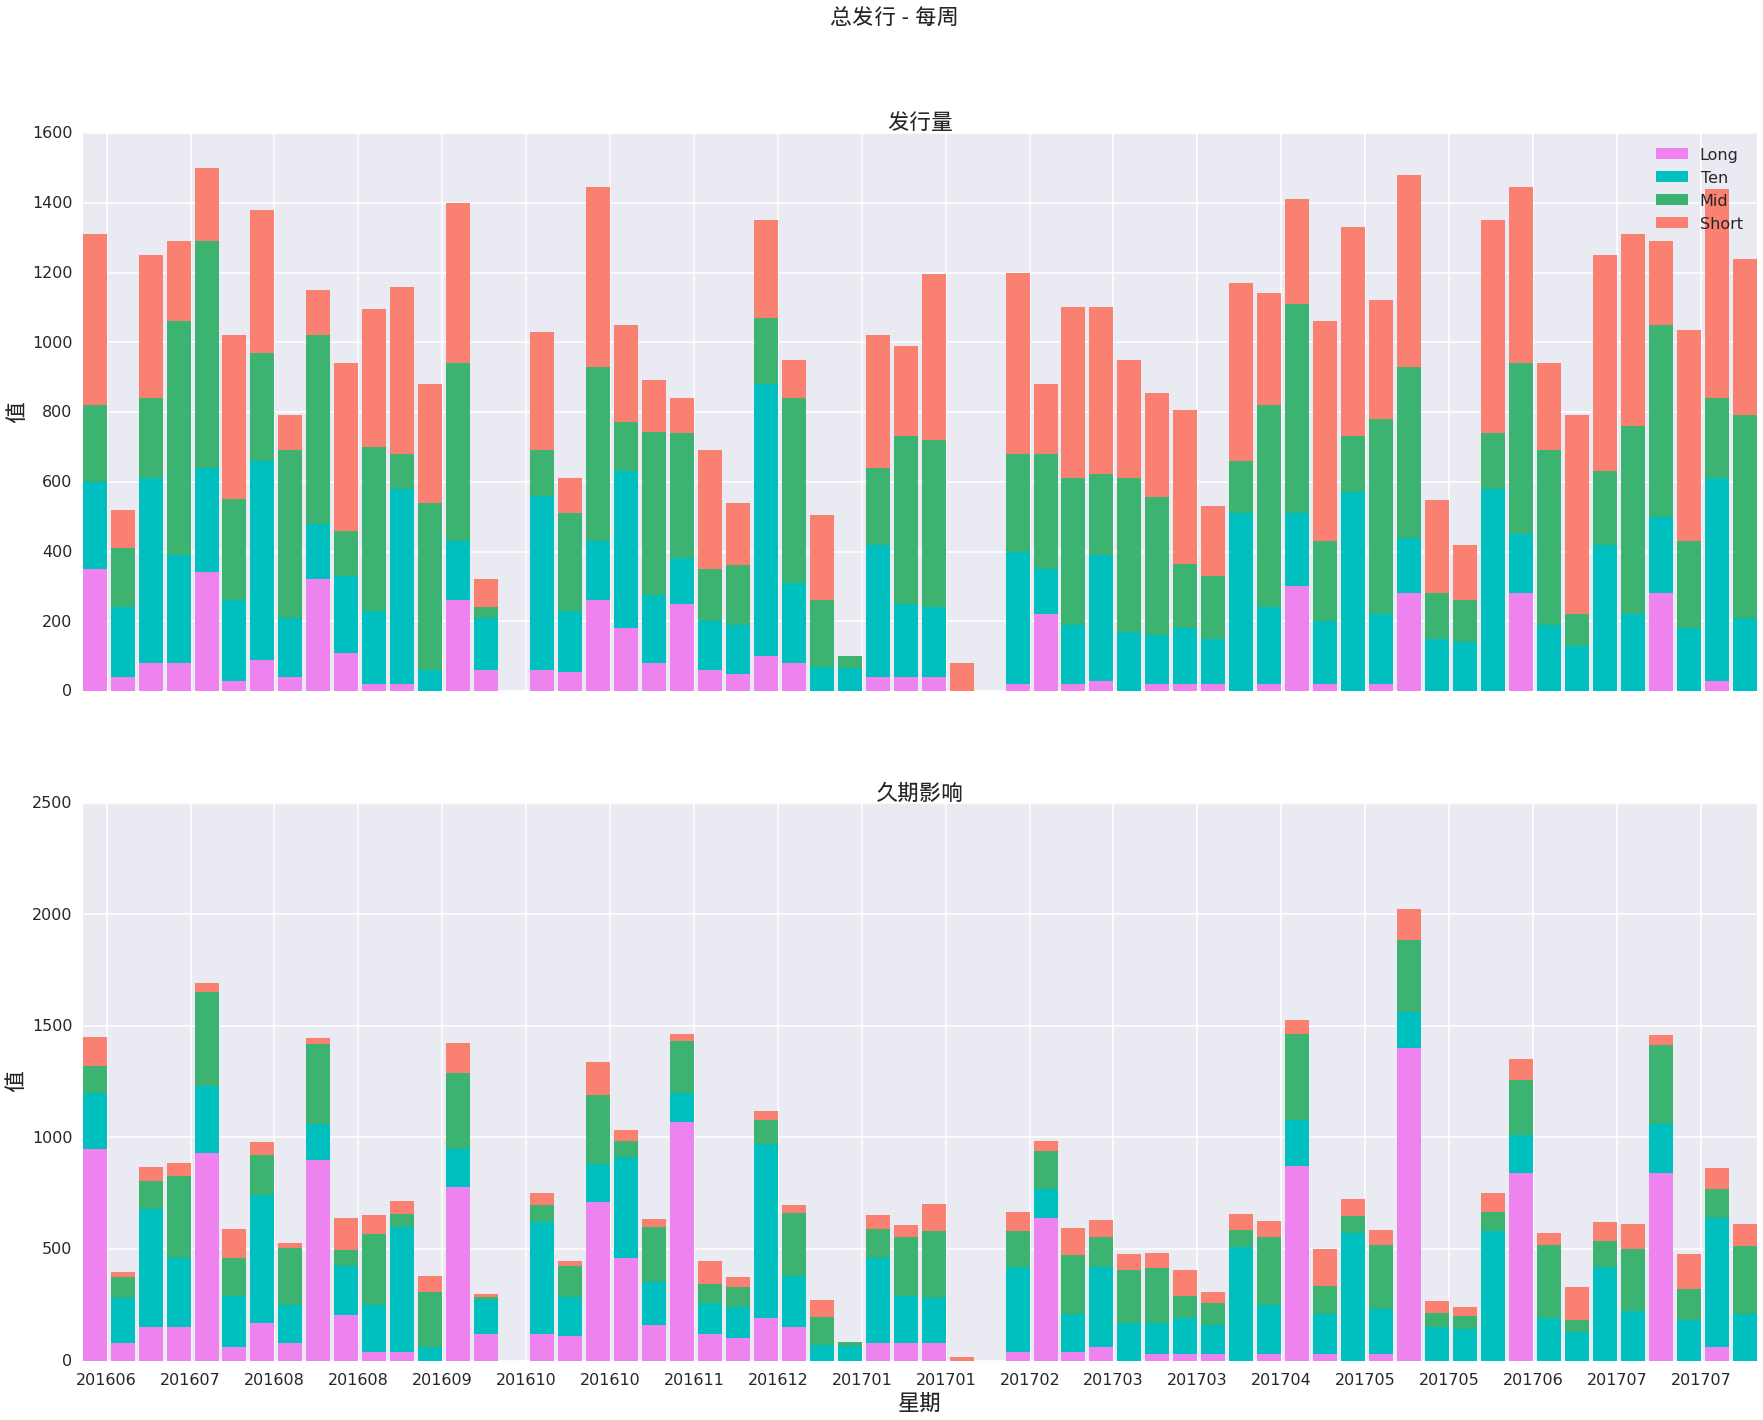

In [704]:
def plot_total_issuance_week(df):
    df = df.copy()
    df.index = df.loc[:, 'dt.week']
    
    grouped = df.groupby(by=['dt.week', 'sector'], as_index=False)
    weekly_sum = grouped.agg({'amt.issue': np.sum, 'dur.impact': np.sum})
    
    mask = np.logical_and(weekly_sum.loc[:, 'dt.week'] >= datetime.date(td.year, td.month, td.day) - datetime.timedelta(420), 
                          weekly_sum.loc[:, 'dt.week'] < datetime.date(td.year, td.month, td.day) + datetime.timedelta(14))
    weekly_sum = weekly_sum.loc[mask, :]
    
    df_issue_plot = get_factors(weekly_sum, 'amt.issue', 'dt.week', 'sector')
    df_impact_plot = get_factors(weekly_sum, 'dur.impact', 'dt.week', 'sector')
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(30, 22), dpi=300)
    common_styles = {'edgecolor': '', 'width': 6.0}
    
    last_values = np.zeros(df_issue_plot.shape[0], dtype=float)
    for sector, color in SECTOR_COLOR_MAP.iteritems():
        ax1.bar(df_issue_plot.index, df_issue_plot.loc[:, sector], bottom=last_values,
                color=color, label=sector, **common_styles)
        last_values += df_issue_plot.loc[:, sector].values
    ax1.set_ylabel(u"值", fontproperties=zhfont)
    
    last_values = np.zeros(df_impact_plot.shape[0], dtype=float)
    for sector, color in SECTOR_COLOR_MAP.iteritems():
        ax2.bar(df_impact_plot.index, df_impact_plot.loc[:, sector], bottom=last_values,
                color=color, label=sector, **common_styles)
        last_values += df_impact_plot.loc[:, sector].values
    ax2.set_ylabel(u"值", fontproperties=zhfont)
    
    
    ax2.xaxis.set_ticks(pd.date_range(start=df_impact_plot.index[0], end=df_impact_plot.index[-1], freq='3W'))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y%m'))
    
    ax1.legend(loc='upper right')
    ax2.set_xlabel(u"星期", fontproperties=zhfont)
    
    plt.suptitle(u"总发行 - 每周", fontproperties=zhfont)
    ax1.set_title(u"发行量", fontproperties=zhfont)
    ax2.set_title(u"久期影响", fontproperties=zhfont)
#     ax2.set_xlabel("dt.week")
#     ax1.set_ylabel("value")
#     plt.suptitle("Total Issuance - weekly", fontproperties=zhfont)
#     ax1.set_title("amt.issue")
#     ax2.set_title("dur.impact")
    return fig

fig = plot_total_issuance_week(data_plot)
fig.savefig('RATES_2.png', bbox_inches='tight')

### Total Issuance Amt - weekly by Issuer

In [475]:
data_plot.head()

,dt.issue,dt.week,dt.month,term,sector,issuer.name,amt.issue,dur.impact
7859,2013-01-09,2013-01-07,2013-01-01,5,Mid,国债,260,130
13946,2016-02-24,2016-02-22,2016-02-01,20,Long,农发,30,60
20597,2013-01-08,2013-01-07,2013-01-01,7,Mid,国开,60,42
21468,2013-09-13,2013-09-09,2013-09-01,30,Long,国债,260,780
23327,2013-03-15,2013-03-11,2013-03-01,10,Ten,农发,150,150


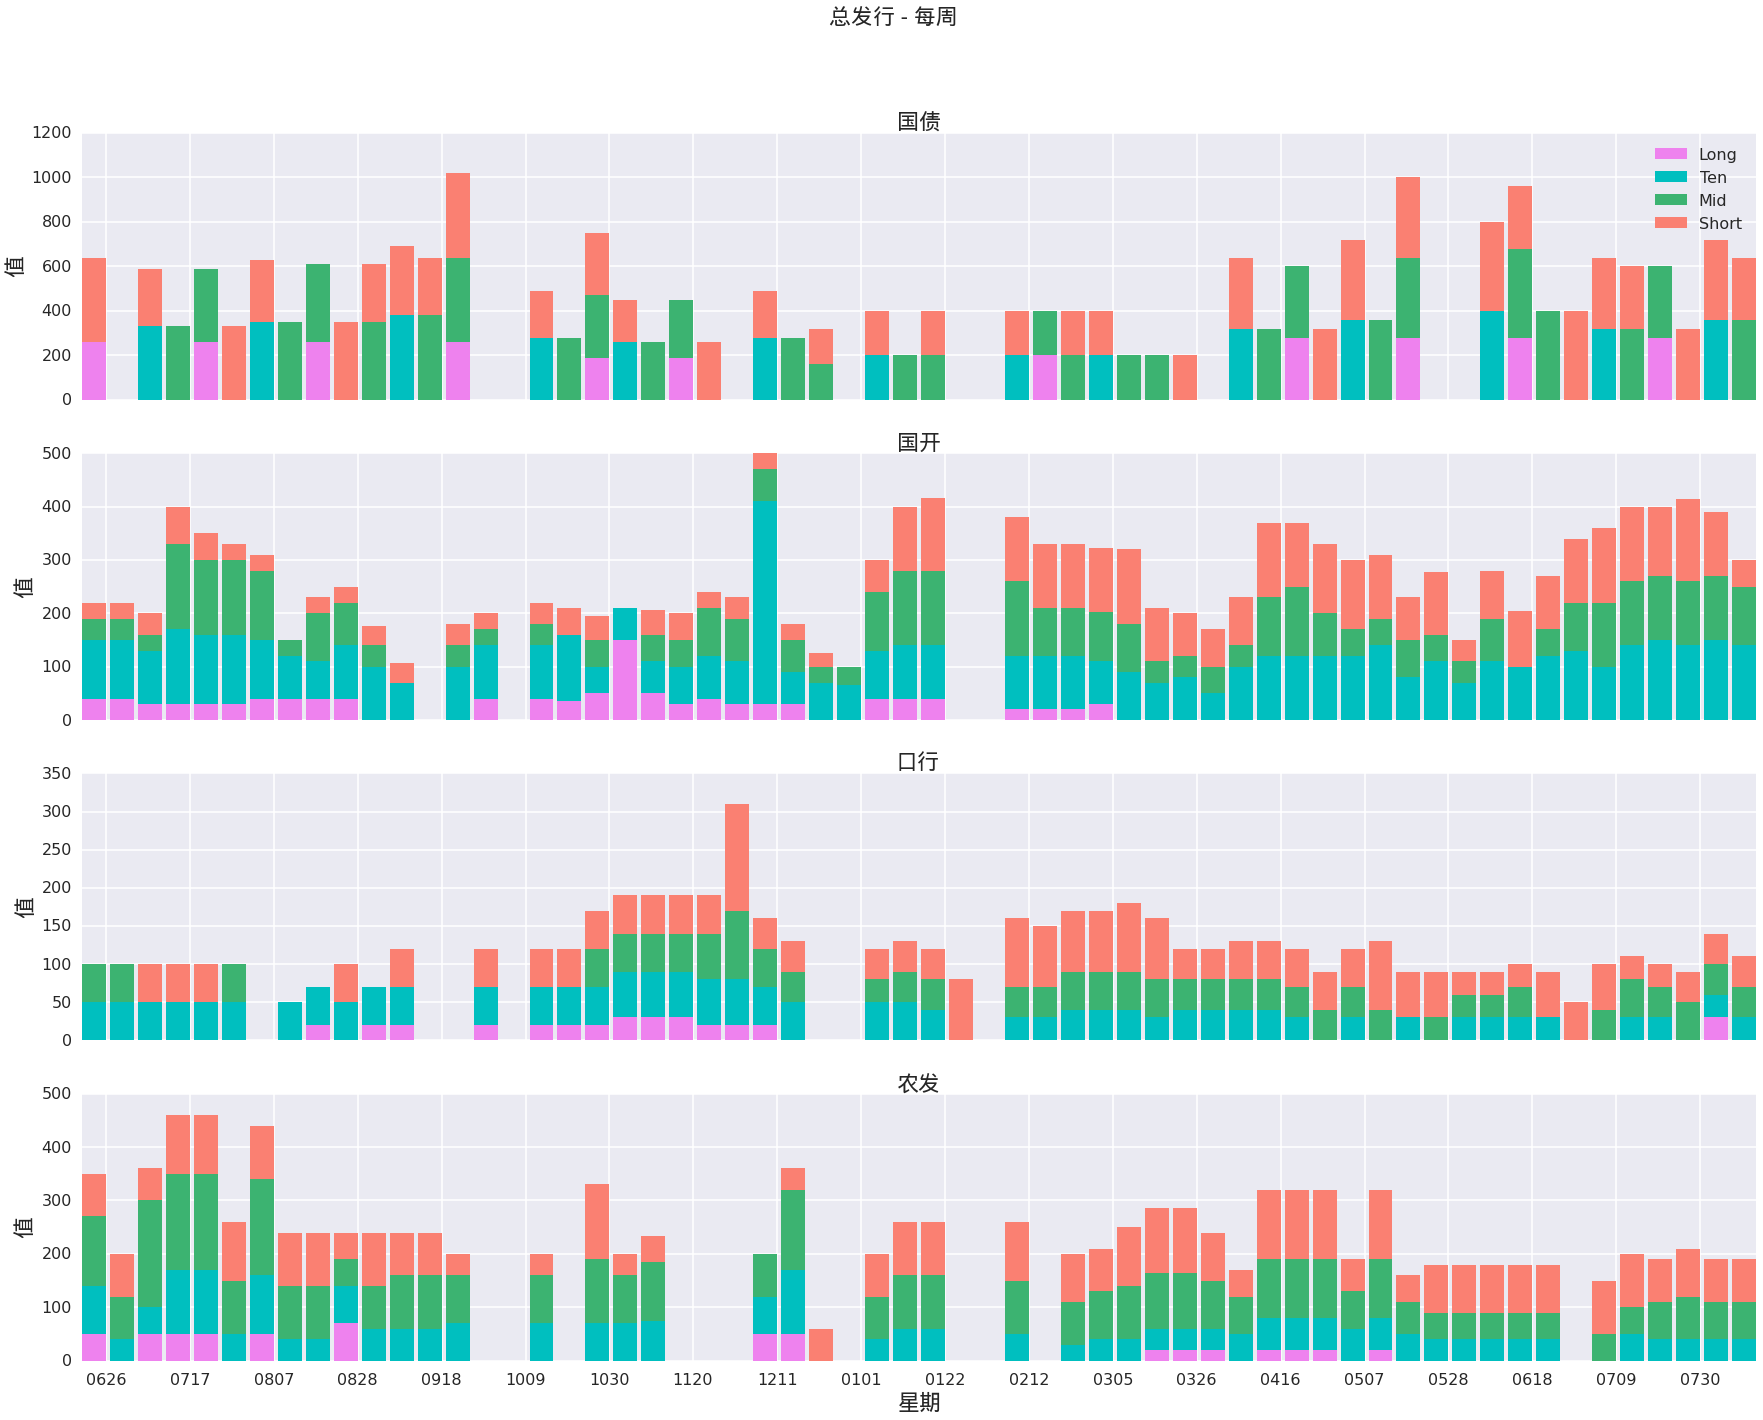

In [706]:
def plot_total_issue_amt_week_issuer(df):
    df = df.copy()
    df.index = df.loc[:, 'dt.week']
    
    grouped = df.groupby(by=['dt.week', 'sector', 'issuer.name'], as_index=False)
    weekly_sum = grouped.agg({'amt.issue': np.sum, 'dur.impact': np.sum})
    
    mask = np.logical_and(weekly_sum.loc[:, 'dt.week'] >= datetime.date(td.year, td.month, td.day) - datetime.timedelta(420), 
                          weekly_sum.loc[:, 'dt.week'] < datetime.date(td.year, td.month, td.day) + datetime.timedelta(14))
    weekly_sum = weekly_sum.loc[mask, :]
    
    df_issuers = {}
    for issuer in ISSUER_RANK.keys():
        df_issuer = weekly_sum.loc[weekly_sum.loc[:, 'issuer.name'] == issuer, :]
        df_issuers[issuer] = get_factors(df_issuer, 'amt.issue', 'dt.week', 'sector')
    
    fig, axes = plt.subplots(len(ISSUER_RANK.keys()), 1, sharex=True, figsize=(30, 22), dpi=300)
    common_styles = {'edgecolor': '', 'width': 6.0}
    
    i = 3
    for issuer, df_plot in df_issuers.iteritems():
        last_values = np.zeros(df_plot.shape[0], dtype=float)
        for sector, color in SECTOR_COLOR_MAP.iteritems():
            axes[i].bar(df_plot.index, df_plot.loc[:, sector], bottom=last_values,
                        color=color, label=sector, **common_styles)
            last_values += df_plot.loc[:, sector].values
        axes[i].set_ylabel(u"值", fontproperties=zhfont)
        axes[i].set_title(issuer, fontproperties=zhfont)
        i -= 1
    
    axes[-1].xaxis.set_ticks(pd.date_range(start=df_plot.index[0], end=df_plot.index[-1], freq='3W'))
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%m%d'))
    axes[0].legend(loc='upper right')
    #axes[-1].set_xlabel("dt.week")
    axes[-1].set_xlabel(u"星期", fontproperties=zhfont)
    plt.suptitle(u"总发行 - 每周", fontproperties=zhfont)
    #plt.suptitle(u"Total Issuance - weekly", fontproperties=zhfont)
    return fig

fig = plot_total_issue_amt_week_issuer(data_plot)
fig.savefig('RATES_3.png', bbox_inches='tight')

### Total Issuance Duration - weekly by Issuer

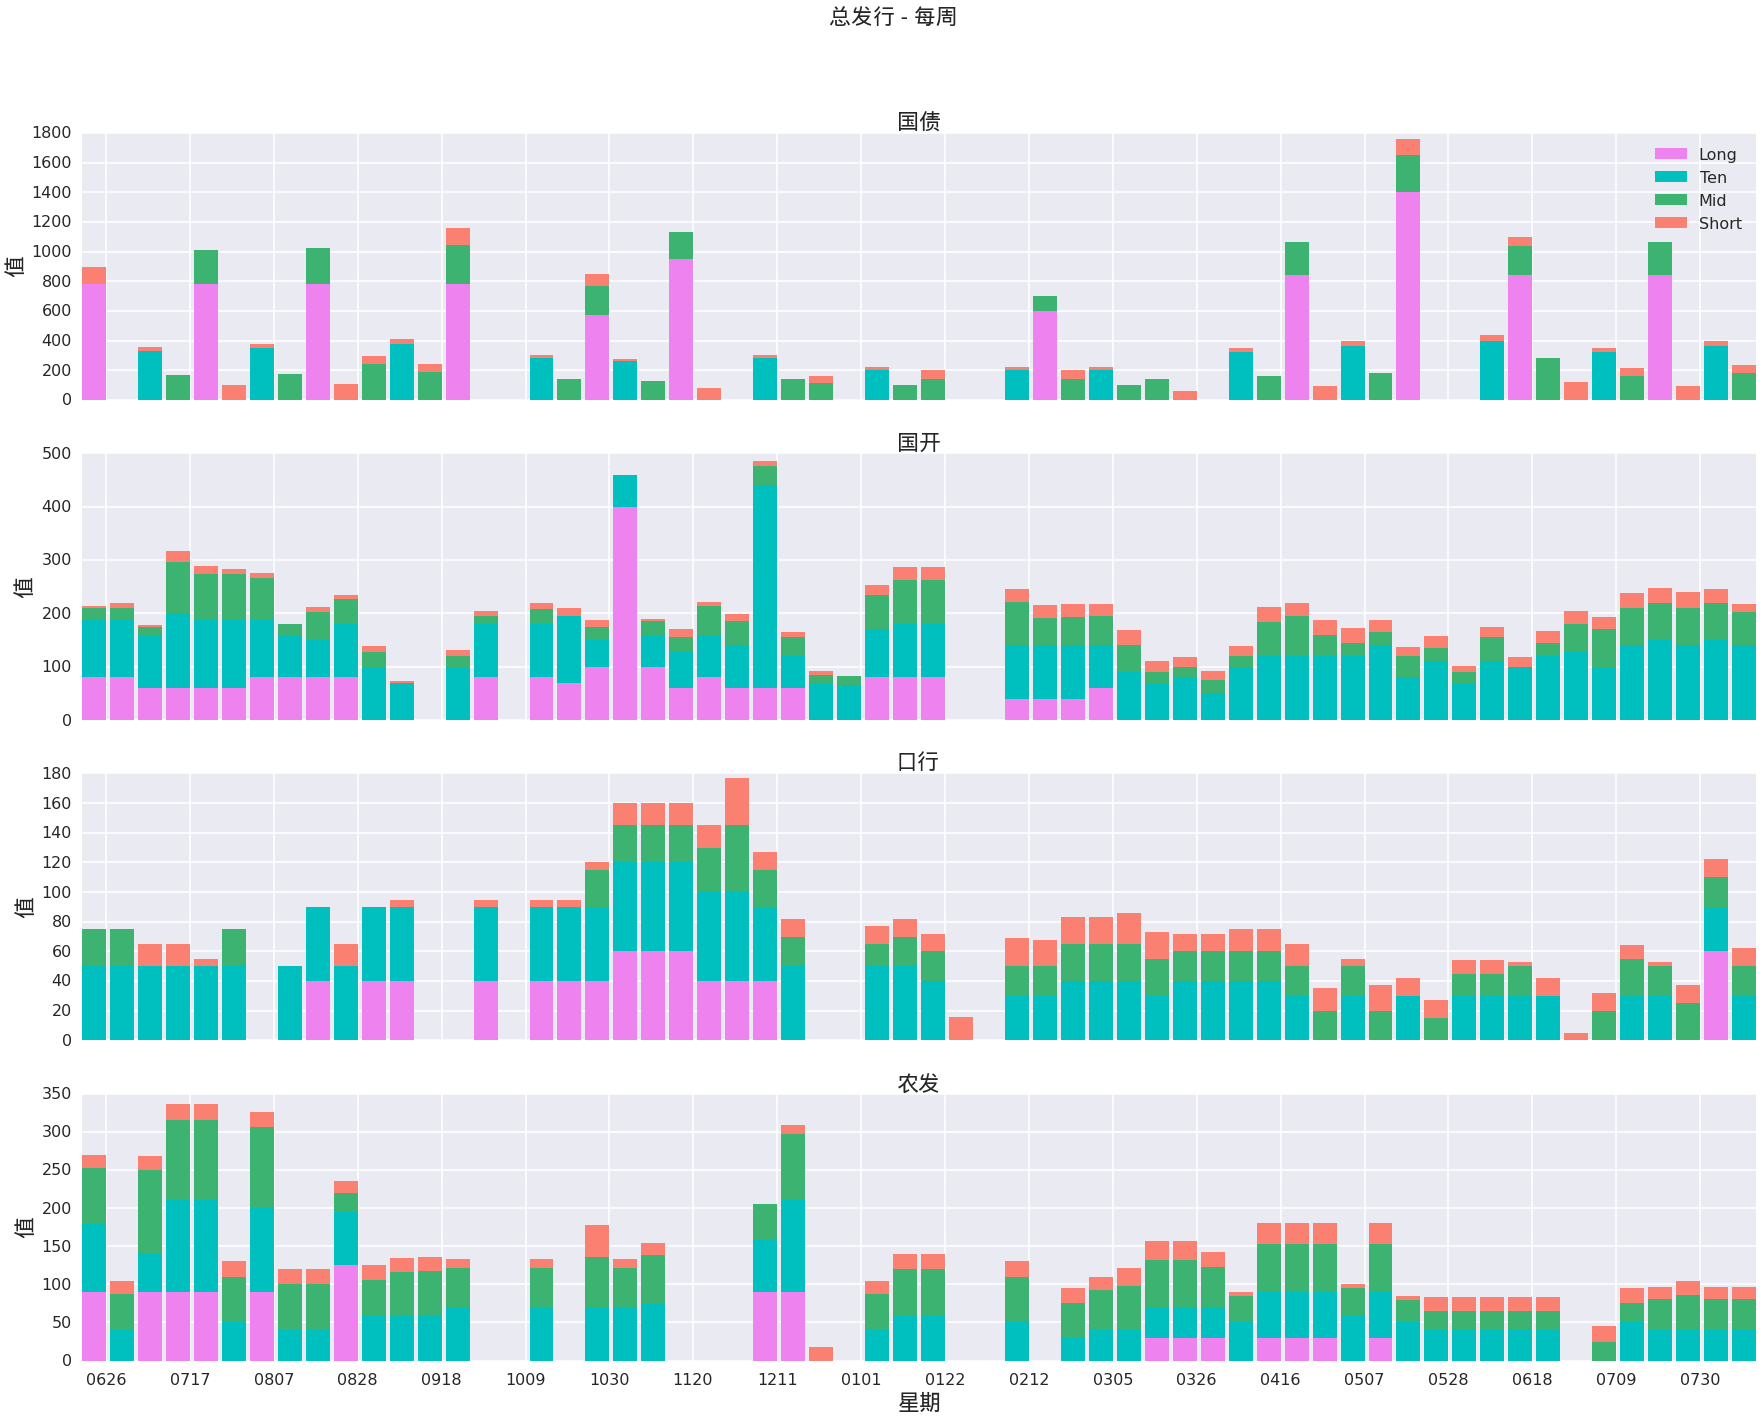

In [717]:
def plot_total_dur_impact_week_issuer(df):
    df = df.copy()
    df.index = df.loc[:, 'dt.week']
    
    grouped = df.groupby(by=['dt.week', 'sector', 'issuer.name'], as_index=False)
    weekly_sum = grouped.agg({'amt.issue': np.sum, 'dur.impact': np.sum})
    
    mask = np.logical_and(weekly_sum.loc[:, 'dt.week'] >= datetime.date(td.year, td.month, td.day) - datetime.timedelta(420), 
                          weekly_sum.loc[:, 'dt.week'] < datetime.date(td.year, td.month, td.day) + datetime.timedelta(14))
    weekly_sum = weekly_sum.loc[mask, :]
    
    df_issuers = {}
    for issuer in ISSUER_RANK.keys():
        df_issuer = weekly_sum.loc[weekly_sum.loc[:, 'issuer.name'] == issuer, :]
        df_issuers[issuer] = get_factors(df_issuer, 'dur.impact', 'dt.week', 'sector')
    
    fig, axes = plt.subplots(len(ISSUER_RANK.keys()), 1, sharex=True, figsize=(30, 22), dpi=300)
    common_styles = {'edgecolor': '', 'width': 6.0}
    
    i = 3
    for issuer, df_plot in df_issuers.iteritems():
        last_values = np.zeros(df_plot.shape[0], dtype=float)
        for sector, color in SECTOR_COLOR_MAP.iteritems():
            axes[i].bar(df_plot.index, df_plot.loc[:, sector], bottom=last_values,
                        color=color, label=sector, **common_styles)
            last_values += df_plot.loc[:, sector].values
        axes[i].set_ylabel(u"值", fontproperties=zhfont)
        axes[i].set_title(issuer, fontproperties=zhfont)
        i -= 1
    
    axes[-1].xaxis.set_ticks(pd.date_range(start=df_plot.index[0], end=df_plot.index[-1], freq='3W'))
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%m%d'))
    axes[0].legend(loc='upper right')
    #axes[-1].set_xlabel("dt.week")
    axes[-1].set_xlabel(u"星期", fontproperties=zhfont)
    #plt.suptitle("Total Issuance - weekly", fontproperties=zhfont)
    plt.suptitle(u"总发行 - 每周", fontproperties=zhfont)
    return fig

fig = plot_total_dur_impact_week_issuer(data_plot)
fig.savefig('RATES_4.png', bbox_inches='tight')

### Bid-Cover ratio by Sector

In [564]:
grouped = data_x.groupby(by='sector')
grouped.get_group('Long')

,amt.issue,bidder.in,bidder.max,bidder.won,bids.effect,bids.win,cpn,dt.carry,dt.diff,dt.issue,dt.list,dt.mature,failure,id.ticker,issuer,name,over.sub.ratio,px.ticker,ref.dt,ref.ticker,
13946,30,38,82,14,98,24,3.95,20160226,NaT,2016-02-24,2016-03-01,2036-02-26,0,160410.IB,04M5F620A3,16农发10,4.61,160410.IB,NaT,NaN,...
21468,260,50,50,49,192,181,4.76,20130916,NaT,2013-09-13,2013-09-23,2043-09-16,0,130019.IB,2000850,13附息国债19,1.13,130019.IB,NaT,NaN,...
45698,50,10,11,8,103,36,3.88,20160112,NaT,2015-12-29,2016-01-14,2036-01-12,0,150319.IB,0MT64BBFB6,15进出19,3.02,150319.IB,NaT,NaN,...
47400,40,24,76,14,98,40,3.80,20160125,NaT,2016-01-21,2016-01-27,2036-01-25,0,160205.IB,2002700,16国开05,3.56,160205.IB,NaT,NaN,...
53010,100,12,12,12,170,51,3.50,20161104,NaT,2016-11-02,2016-11-08,2046-11-04,0,160216.IB,2002700,16国开16,3.20,160216.IB,NaT,NaN,...
83516,200,50,51,33,169,58,4.24,20130520,NaT,2013-05-17,2013-05-24,2063-05-20,0,130010.IB,2000850,13附息国债10,2.13,130010.IB,NaT,NaN,...
86784,260,51,51,39,233,66,3.99,20130422,NaT,2013-04-19,2013-04-26,2033-04-22,0,130009.IB,2000850,13附息国债09,2.23,130009.IB,NaT,NaN,...
126071,80,5,5,5,60,30,5.24,20140704,NaT,2014-06-27,2014-07-10,2029-07-04,0,140217.IB,2002700,14国开17,1.95,140217.IB,NaT,NaN,...
158300,50,35,82,34,56,56,3.95,20160226,NaT,2016-02-24,2016-03-01,2031-02-26,0,160409.IB,04M5F620A3,16农发09,1.44,160409.IB,NaT,NaN,...
2406093,260,50,50,50,241,164,4.32,20130812,109 days,2013-08-09,2013-08-16,2033-08-12,0,130016.IB,2000850,13附息国债16,1.56,130016.IB,2013-04-22,130009.IB,...


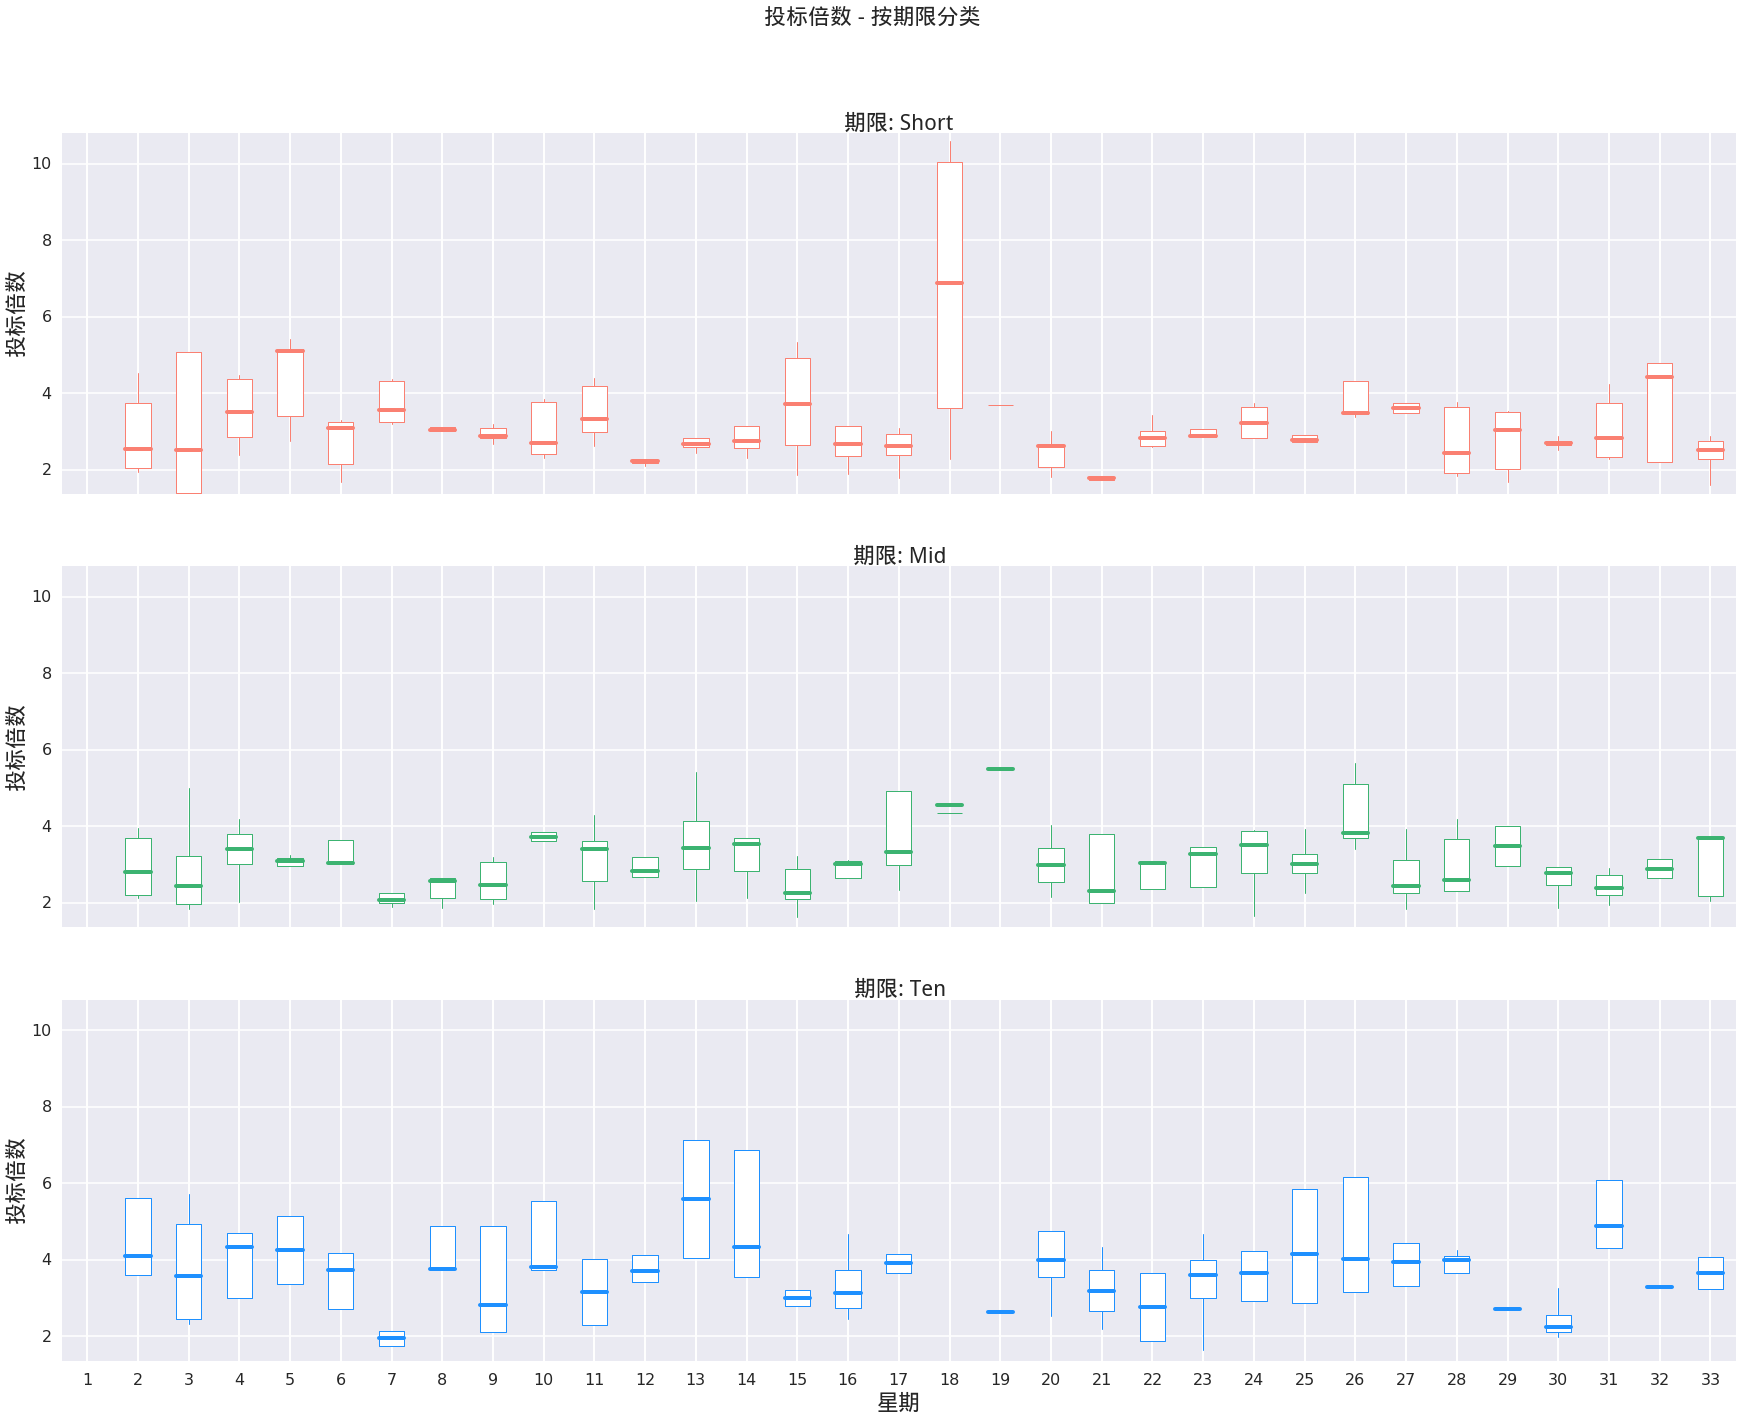

In [733]:
def bp_set_box(elem, box_color='red'):
    elem.set_color('white')
    elem.set_edgecolor(box_color)
    elem.set_linewidth(1)

def bp_set_median(elem, box_color='red'):
    elem.set_color(box_color)
    elem.set_linewidth(4)

def bp_set_whisker(elem, box_color='red'):
    elem.set_linestyle('-')
    elem.set_color(box_color)
    elem.set_linewidth(1)

def bp_set_cap(elem):
    global box_color
    elem.set_alpha(0.0)

def plot_bc_ratio_sector(df, yname, title="", ynamecn=u""):
    df = df.copy()
    df.index = df.loc[:, 'dt.week']
    
    mask = df.loc[:, 'dt.week'] >= (datetime.date(td.year, td.month, td.day) - datetime.timedelta(240))
    df = df.loc[mask, :]
    
    ylim = df.loc[:, yname].min() * 0.98, df.loc[:, yname].max() * 1.02
    
    grouped = df.groupby(by='sector', as_index=False)
    
    sector_colors = ['salmon', 'mediumseagreen', 'dodgerblue']
    sector_selected = ['Short', 'Mid', 'Ten']
    fig, axes = plt.subplots(len(sector_selected), 1, sharex=True, figsize=(30, 22), dpi=300)
    common_styles = {'sym': '+', 'vert': True, 'patch_artist': True}
    
    for i, sector in enumerate(sector_selected):
        df_plot = grouped.get_group(sector)
        df_plot = df_plot.loc[:, ['dt.week', yname]]
        grouped2 = df_plot.groupby(by='dt.week', as_index=False)
        
        box_data = []
        for week, idx in grouped2.groups.iteritems():
            box_data.append(df_plot.loc[idx, yname].values)
        
        bp_res = axes[i].boxplot(box_data, **common_styles)
        
        box_color = sector_colors[i]
        map(lambda x: bp_set_box(x, box_color), bp_res['boxes'])
        map(lambda x: bp_set_median(x, box_color), bp_res['medians'])
        map(lambda x: bp_set_whisker(x, box_color), bp_res['whiskers'])
        map(bp_set_cap, bp_res['caps'])
        plt.setp(bp_res['fliers'], color='red', marker='+')
        
        axes[i].set_ylim(ylim)
        axes[i].set_title(u"期限: " + sector, fontproperties=zhfont)#TODOzhch期限
        axes[i].set_ylabel(ynamecn, fontproperties=zhfont)#TODOzhcn投标倍数
    
    weeks = map(lambda dt: dt.strftime("%Y%m%d"), grouped2.groups.keys())
    axes[-1].set_xticks(range(1, 34), ['lll']*33)
    axes[-1].set_xlabel(u"星期", fontproperties=zhfont)
    plt.suptitle(title, fontproperties=zhfont)#TODOzhcn
    return fig

fig = plot_bc_ratio_sector(data_x, 'over.sub.ratio', u"投标倍数 - 按期限分类", u"投标倍数")#"Bid Cover Ratio by Sector")
fig.savefig('RATES_5.png', bbox_inches='tight')

### Bid-Cover ratio by Issuer

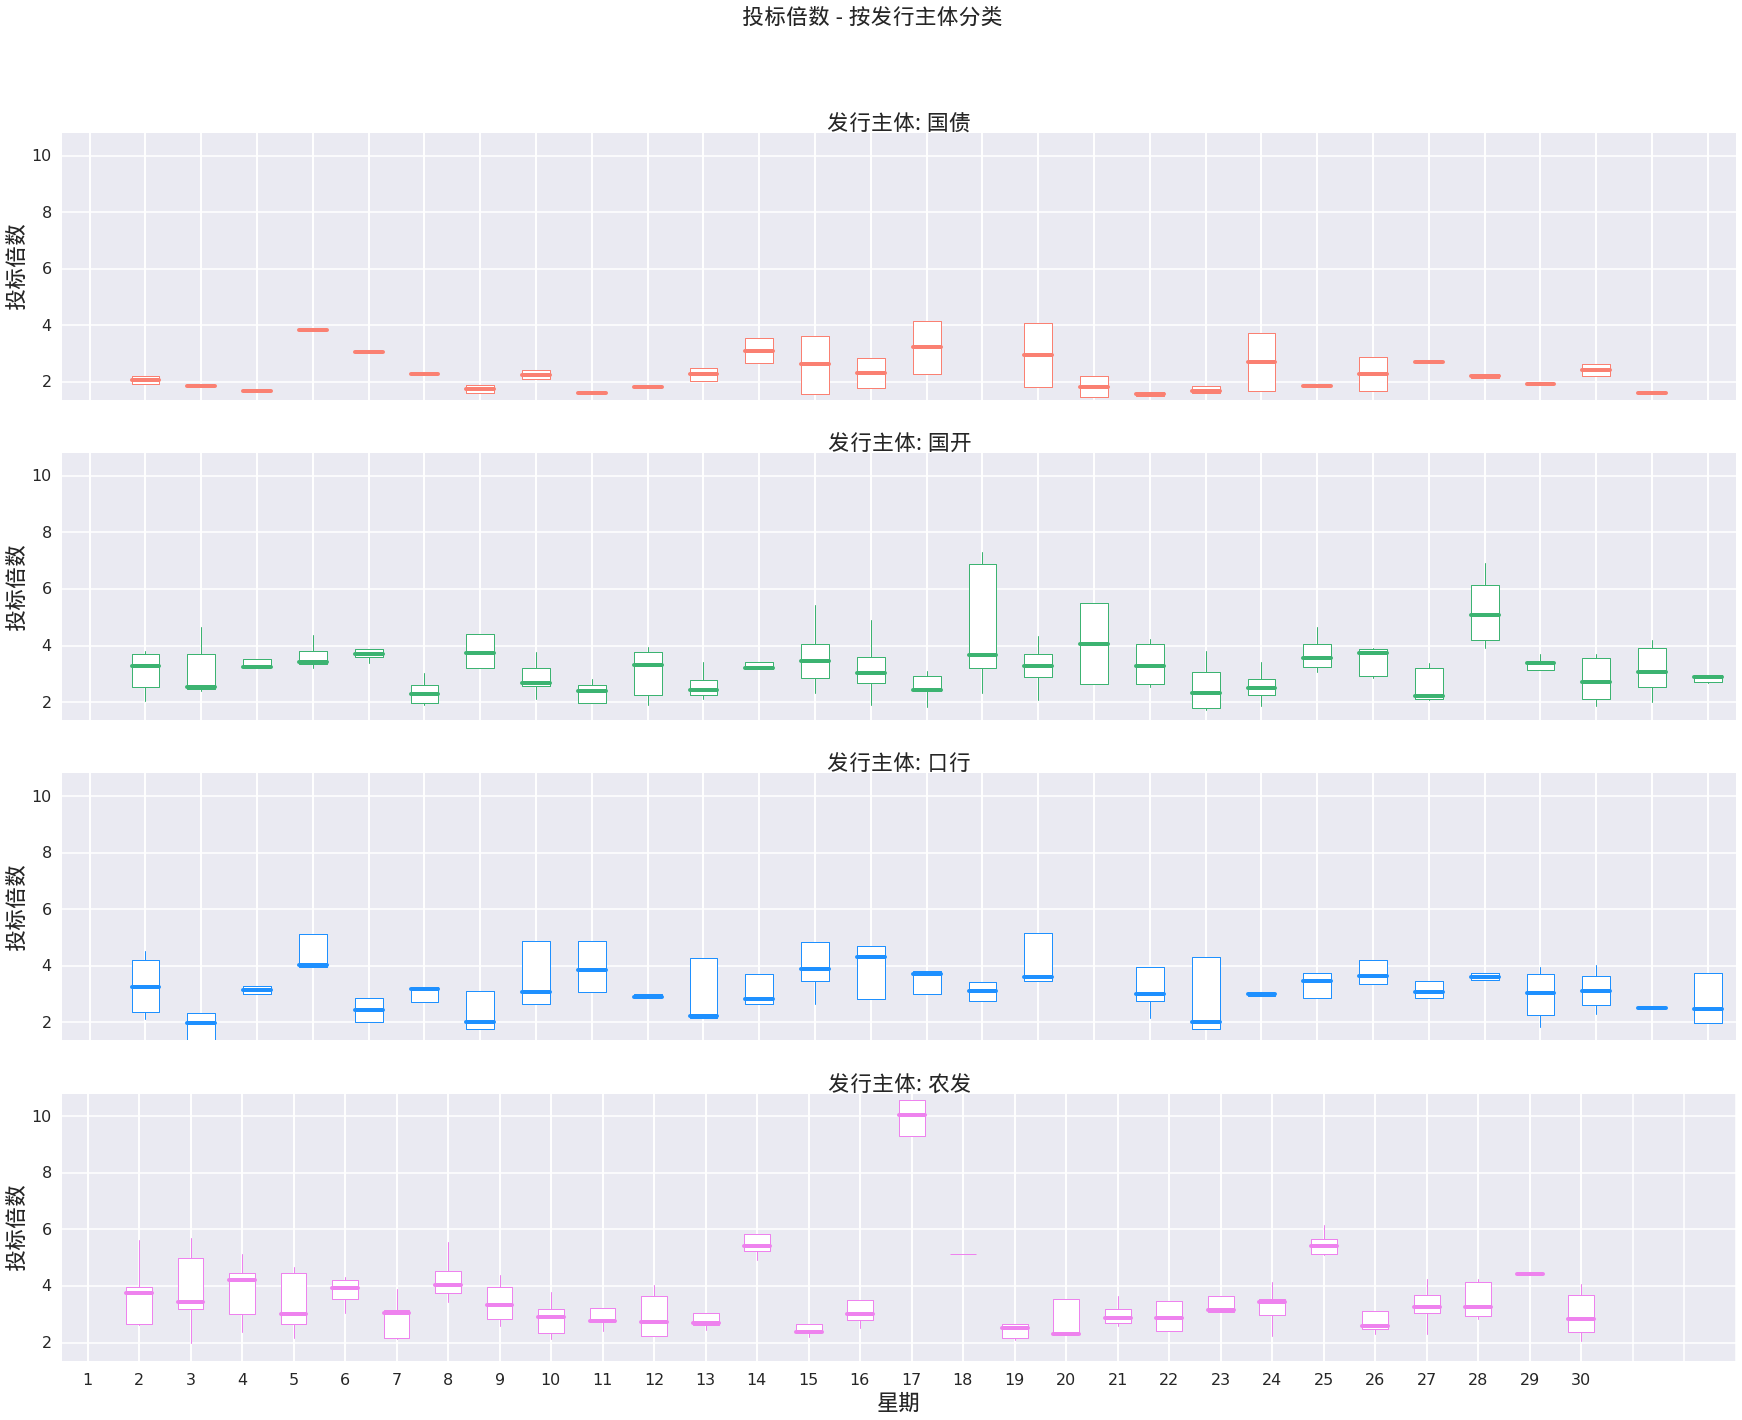

In [734]:
def plot_bc_ratio_issuer(df, yname, title="", ynamecn=u""):
    df = df.copy()
    df.index = df.loc[:, 'dt.week']
    
    mask = df.loc[:, 'dt.week'] >= (datetime.date(td.year, td.month, td.day) - datetime.timedelta(240))
    df = df.loc[mask, :]
    
    ylim = df.loc[:, yname].min() * 0.98, df.loc[:, yname].max() * 1.02
    
    grouped = df.groupby(by='issuer.name', as_index=False)
    
    sector_colors = ['salmon', 'mediumseagreen', 'dodgerblue', 'violet']
    sector_selected = ISSUER_RANK.keys()
    fig, axes = plt.subplots(len(sector_selected), 1, sharex=True, figsize=(30, 22), dpi=300)
    common_styles = {'sym': '+', 'vert': True, 'patch_artist': True}
    
    for i, sector in enumerate(ISSUER_RANK.keys()):
        #print sector
        df_plot = grouped.get_group(sector)
        df_plot = df_plot.loc[:, ['dt.week', yname]]
        grouped2 = df_plot.groupby(by='dt.week', as_index=False)
        
        box_data = []
        for week, idx in grouped2.groups.iteritems():
            box_data.append(df_plot.loc[idx, yname].values)
        
        bp_res = axes[i].boxplot(box_data, **common_styles)
        
        box_color = sector_colors[i]
        map(lambda x: bp_set_box(x, box_color), bp_res['boxes'])
        map(lambda x: bp_set_median(x, box_color), bp_res['medians'])
        map(lambda x: bp_set_whisker(x, box_color), bp_res['whiskers'])
        map(bp_set_cap, bp_res['caps'])
        plt.setp(bp_res['fliers'], color='red', marker='+')
        
        axes[i].set_ylim(ylim )
        axes[i].set_title(u"发行主体: " + sector, fontproperties=zhfont)
        axes[i].set_ylabel(ynamecn, fontproperties=zhfont)#TODOzhcn
    
    weeks = map(lambda dt: dt.strftime("%Y%m%d"), grouped2.groups.keys())
    axes[-1].set_xticks(range(1, 34), ['lll']*33)
    axes[-1].set_xlabel(u"星期", fontproperties=zhfont)
    plt.suptitle(title, fontproperties=zhfont)#TODOzhcn
    return fig

fig = plot_bc_ratio_issuer(data_x, 'over.sub.ratio', u"投标倍数 - 按发行主体分类", u"投标倍数")#"Bid Cover Ratio by Issuer")
fig.savefig('RATES_6.png', bbox_inches='tight')

### Through-tail by Sector

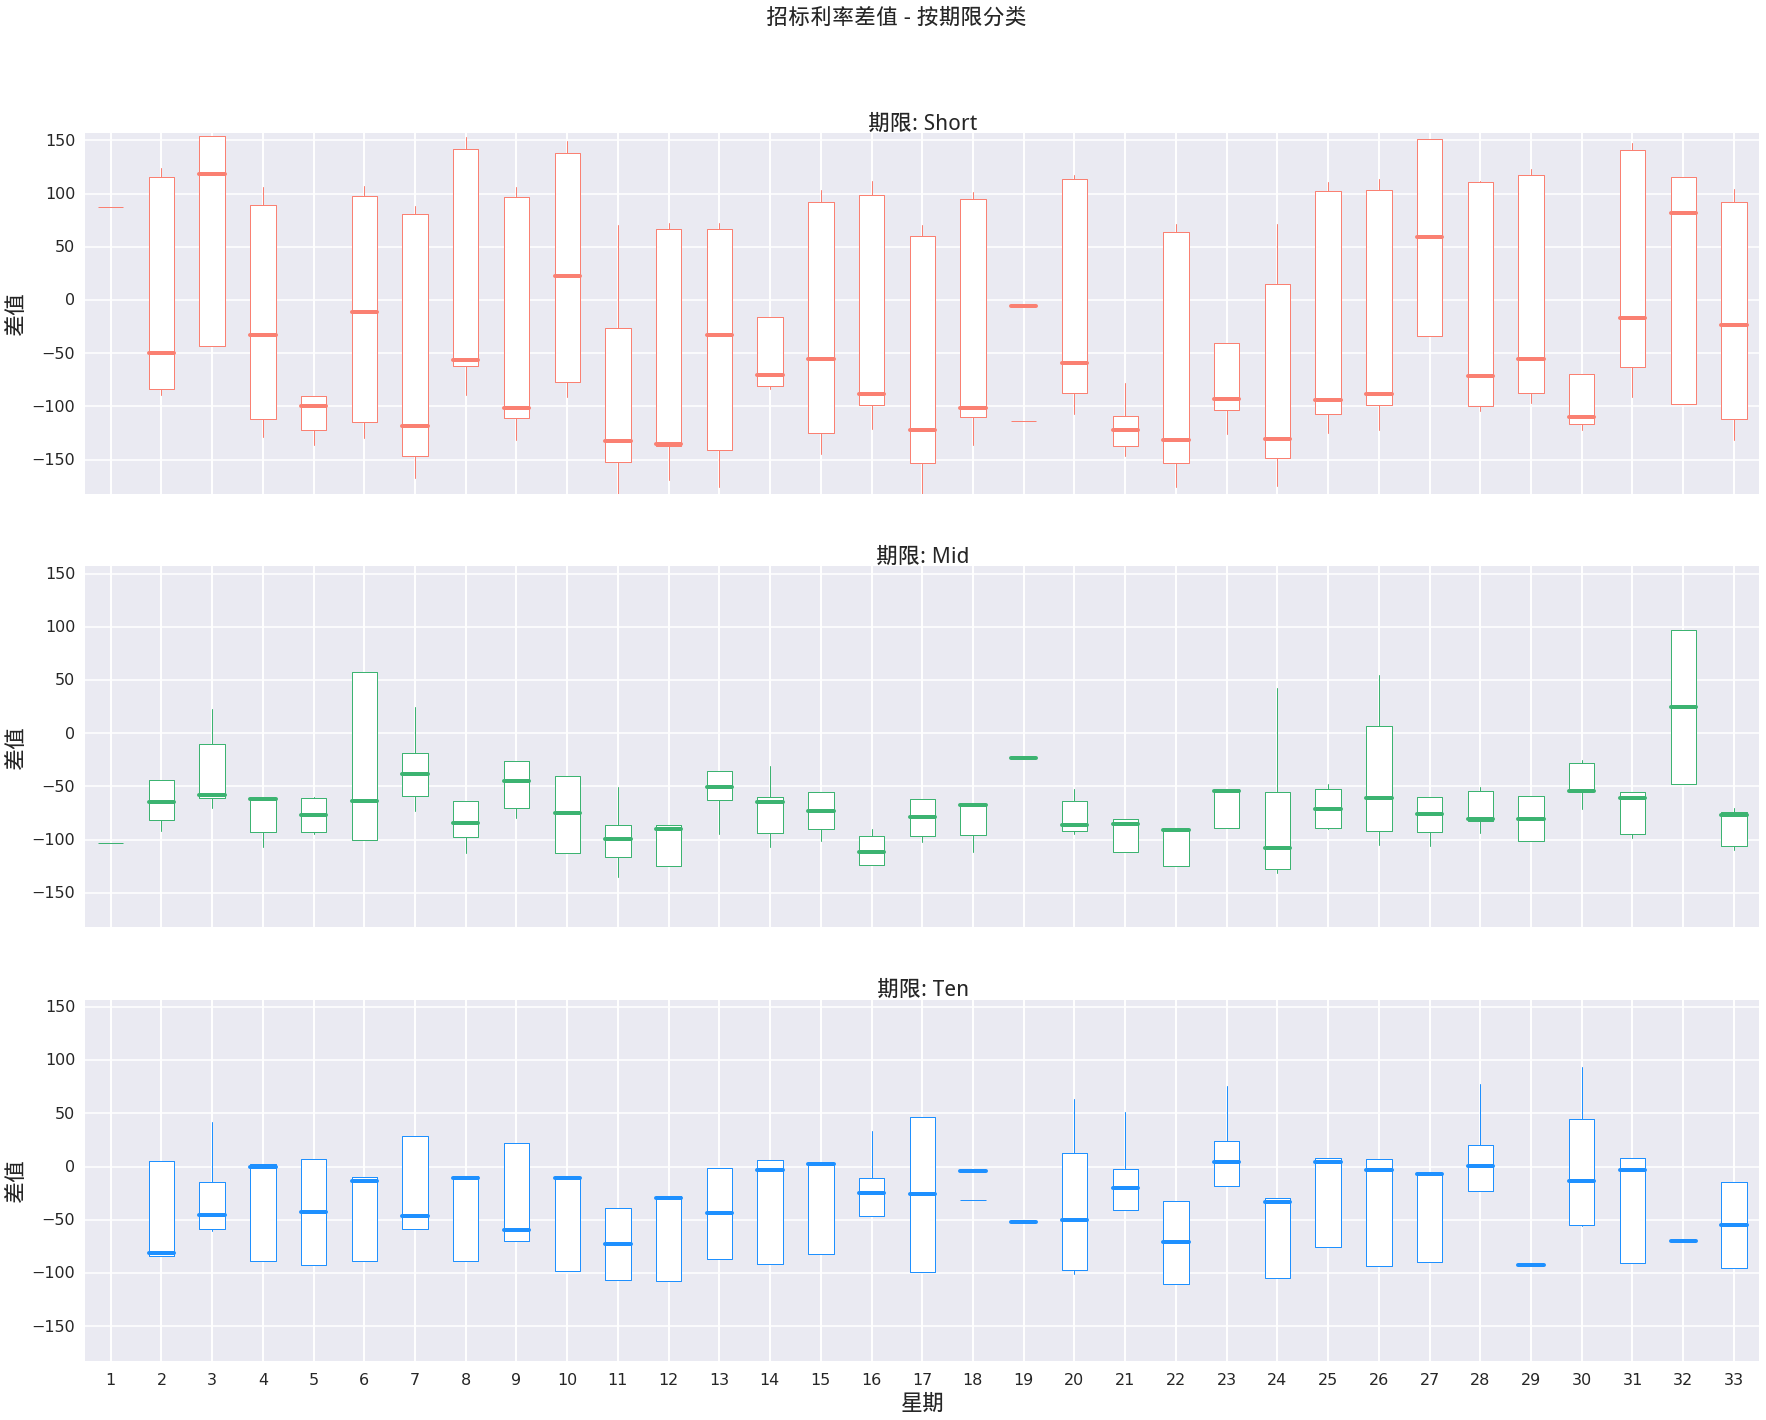

In [735]:
fig = plot_bc_ratio_sector(data_x, 'through', u"招标利率差值 - 按期限分类", u"差值")#TODOzhcn招标利率差值（实际- 市场）
fig.savefig('RATES_7.png', bbox_inches='tight')

### Through-tail by Issuer

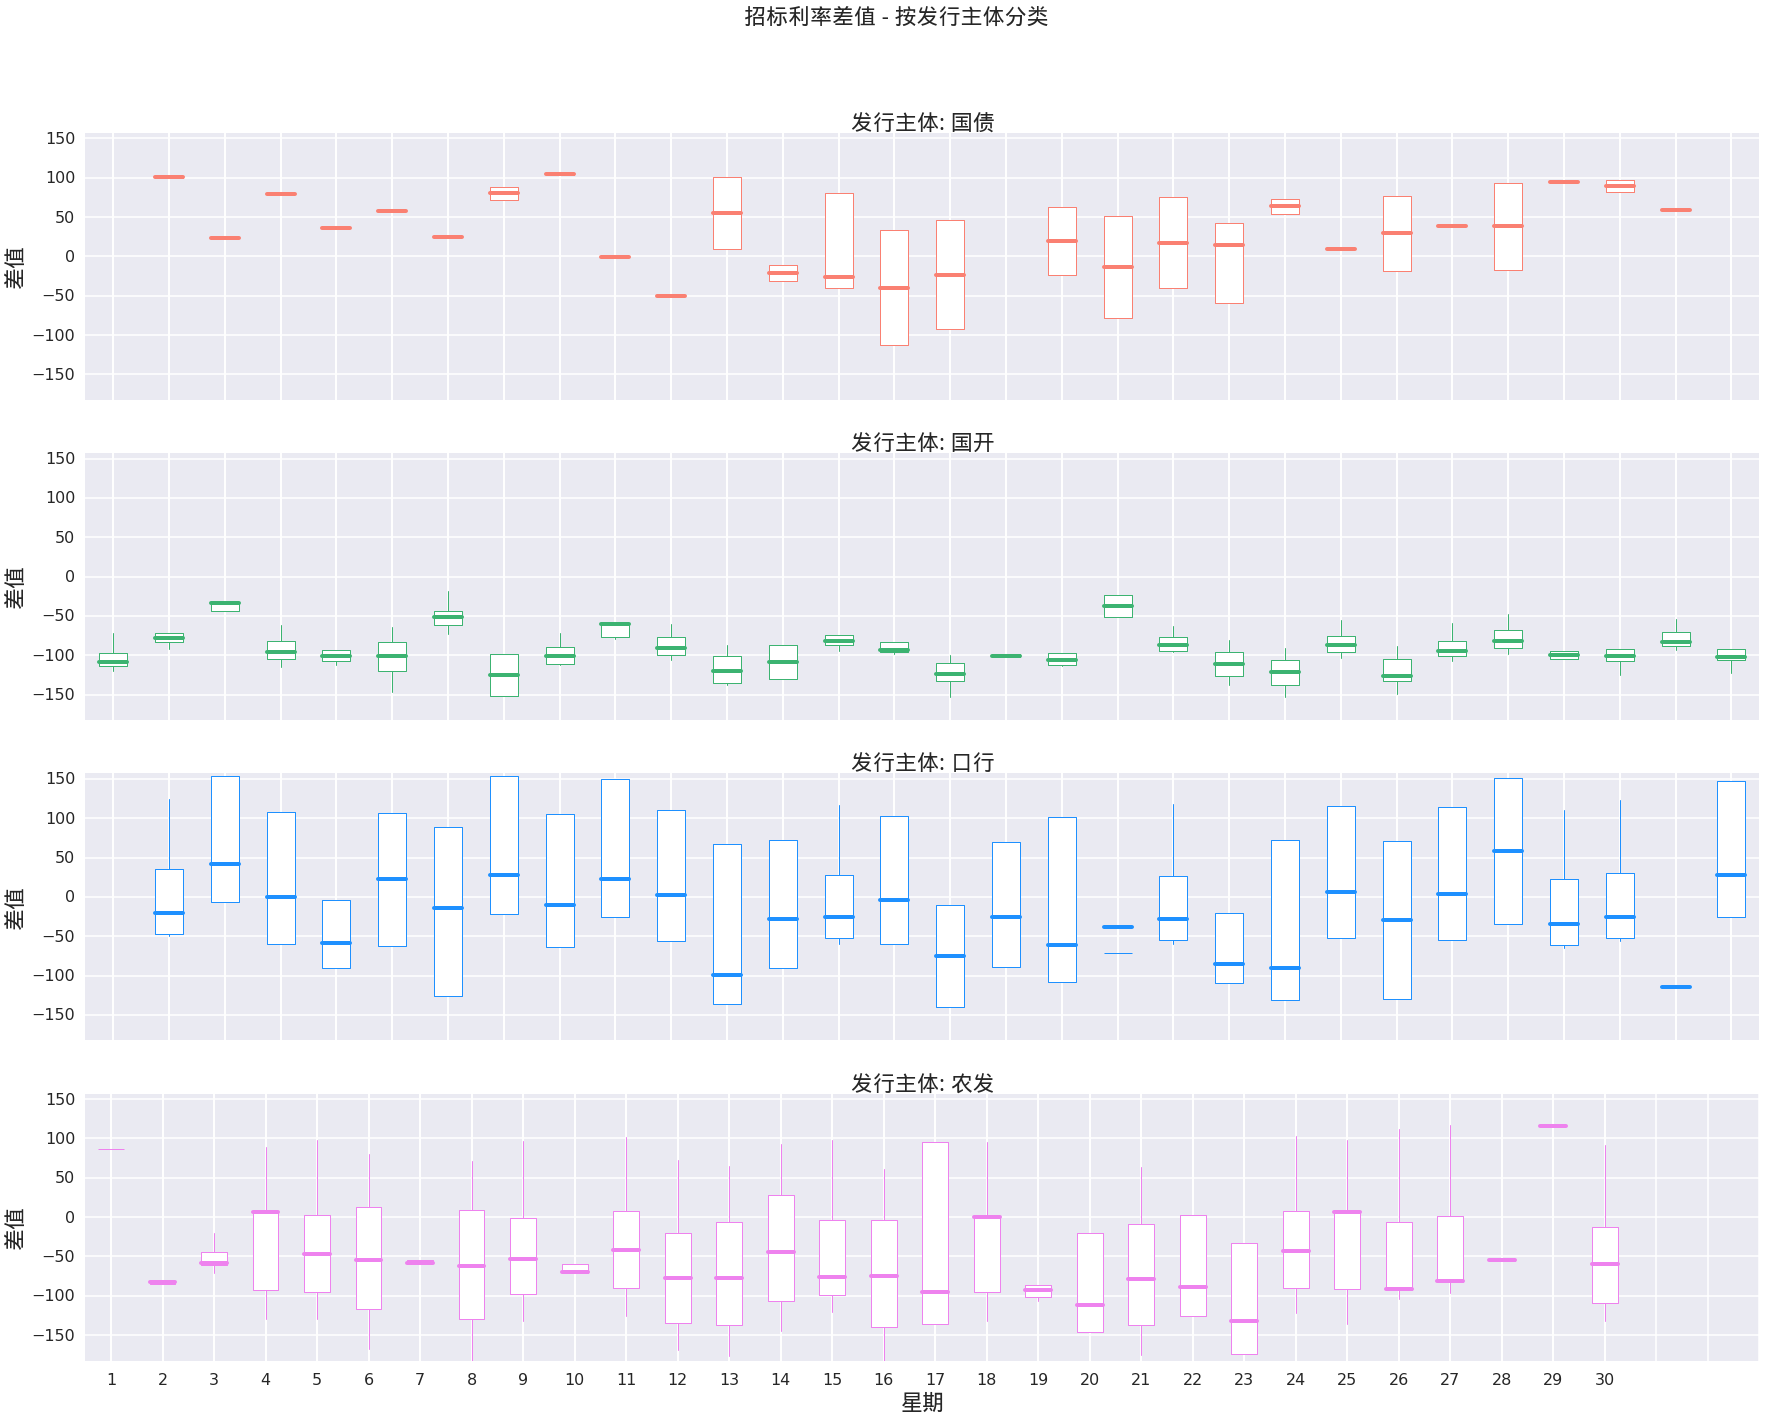

In [736]:
fig = plot_bc_ratio_issuer(data_x, 'through', u"招标利率差值 - 按发行主体分类", u"差值")#"Through/Tail by Issuer")#TODOzhcn
fig.savefig('RATES_8.png', bbox_inches='tight')

In [739]:
from reportlab.pdfgen import canvas
import reportlab.lib.pagesizes as rlps

mypagesize = rlps.A4[1], rlps.A4[0]

def calc_center(pagesize, fig):
    width, height = pagesize
    fw, fh = fig.get_size_inches() * 72.
    
    scale_ratio = width / fw * 0.95
    paint_w, paint_h = fw * scale_ratio, fh * scale_ratio
    x = (width - paint_w) / 2.
    return x, paint_w, paint_h

def draw_one_img_one_page(canvas, img_name, pagesize):
    fig_x, fig_width, fig_height = calc_center(pagesize, fig)
    canvas.drawImage(img_name, fig_x, 20, width=fig_width, height=fig_height)
    canvas.showPage()
    
def generate_PDF(fname='ex'):
    c = canvas.Canvas(fname+'.pdf', pagesize=mypagesize)
    
    from reportlab.pdfbase import pdfmetrics
    from reportlab.pdfbase.ttfonts import TTFont
    pdfmetrics.registerFont(TTFont('wqy', '/home/********/wqy-microhei.ttc'))

    c.setFont("wqy", 50)
    c.drawCentredString(mypagesize[0] / 2, mypagesize[1] * 4. / 5., u"利率债一级市场-大数据汇总")
    fig_width, fig_height = 756./3, 672./3
    c.drawImage("logo.png", (mypagesize[0] - fig_width) / 2., mypagesize[1] / 5, width=fig_width, height=fig_height)
    c.showPage()
    
    for i in range(1, 9):
        draw_one_img_one_page(c, "RATES_{}.png".format(i), mypagesize)
    
    c.save()
    return

generate_PDF("RATES_Stats_"+td_str)